In [2]:
# =============================================================================
# TCN multistep para predecir ff_Valor (usando covariables ya generadas)
# con ff_Valor del año anterior como input
# =============================================================================
import os, random, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ------------------------- reproducibilidad ----------------------------------
SEED = 28371
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# ------------------------- parámetros ----------------------------------------
BASE_FEATURES = ["dd_Valor", "VRB_Valor", "Presion_QFE", "Temperatura", "Presion_QFF"]
CYCLIC_FEATS  = ["hora_sin", "hora_cos", "doy_sin", "doy_cos"]
TARGET_VAR    = ["ff_Valor"]
EXTRA_LAG_VAR = "ff_Valor_lag365"

WINDOW   = 30 * 24
HORIZON  = 30 * 24
TEST_RATIO = 0.2

# ------------------------- 1) datos ------------------------------------------
df = pd.read_excel("Datos_290004_con_predicciones_covariables_filtrado_2024.xlsx")
df["momento"] = pd.to_datetime(df["momento"], dayfirst=True)

df["hora"] = df["momento"].dt.hour
df["doy"]  = df["momento"].dt.dayofyear

df["hora_sin"] = np.sin(2*np.pi*df["hora"] / 24)
df["hora_cos"] = np.cos(2*np.pi*df["hora"] / 24)
df["doy_sin"]  = np.sin(2*np.pi*df["doy"] / 365)
df["doy_cos"]  = np.cos(2*np.pi*df["doy"] / 365)

# Lag de un año
df[EXTRA_LAG_VAR] = df["ff_Valor"].shift(365 * 24)

# Eliminar primeras filas con NaN por lag
df.dropna(subset=[EXTRA_LAG_VAR], inplace=True)

# Historial hasta fecha de corte
CUTOFF = pd.Timestamp("2025-06-23 08:00")
df_hist = df[df["momento"] <= CUTOFF].copy()

# Definir features incluyendo la variable lag
FEATURES = BASE_FEATURES + CYCLIC_FEATS + [EXTRA_LAG_VAR]

X_full = df_hist[FEATURES].values
Y_full = df_hist[TARGET_VAR].values

# ------------------------- 2) ventanas ---------------------------------------
def make_seq(X, Y, win, hor):
    xs, ys = [], []
    last = len(X) - win - hor + 1
    for i in range(last):
        xs.append(X[i : i+win])
        ys.append(Y[i+win : i+win+hor])
    return np.asarray(xs), np.asarray(ys)

X_raw, Y_raw = make_seq(X_full, Y_full, WINDOW, HORIZON)

split = int(len(X_raw) * (1 - TEST_RATIO))
X_train_raw, X_test_raw = X_raw[:split], X_raw[split:]
Y_train_raw, Y_test_raw = Y_raw[:split], Y_raw[split:]

# ------------------------- 3) escalado ---------------------------------------
x_scaler, y_scaler = StandardScaler(), StandardScaler()
x_scaler.fit(X_train_raw.reshape(-1, len(FEATURES)))
y_scaler.fit(Y_train_raw.reshape(-1, 1))

def scale(Xr, Yr):
    Xs = x_scaler.transform(Xr.reshape(-1, len(FEATURES))).reshape(Xr.shape)
    Ys = y_scaler.transform(Yr.reshape(-1, 1)).reshape(Yr.shape)
    return Xs.astype("float32"), Ys.astype("float32")

X_train, Y_train = scale(X_train_raw, Y_train_raw)
X_test,  Y_test  = scale(X_test_raw,  Y_test_raw)

# ------------------------- 4) modelo TCN -------------------------------------
def tcn_block(x, filters, k, d, seed):
    prev = x
    for i in range(2):
        x = layers.Conv1D(filters, k, padding="causal",
                          dilation_rate=d, activation="relu",
                          kernel_initializer=tf.keras.initializers.GlorotUniform(seed+i))(x)
        x = layers.Dropout(0.2, seed=seed+i)(x)
    if prev.shape[-1] != filters:
        prev = layers.Conv1D(filters, 1, padding="same",
                             kernel_initializer=tf.keras.initializers.GlorotUniform(seed))(prev)
    return layers.Activation("relu")(layers.Add()([x, prev]))

inputs = layers.Input(shape=(WINDOW, len(FEATURES)))
x = tcn_block(inputs, 32, 3, 1, SEED)
x = tcn_block(x,      32, 3, 2, SEED+10)
x = tcn_block(x,      32, 3, 4, SEED+20)
x = tcn_block(x,      32, 3, 8, SEED+30)
x = tcn_block(x,      32, 3, 16, SEED+40)
x = tcn_block(x,      32, 3, 32, SEED+50)
x = layers.Flatten()(x)
flat_out = layers.Dense(HORIZON)(x)
outputs  = layers.Reshape((HORIZON, 1))(flat_out)

model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.Huber(delta=0.25))
model.summary()

# ------------------------- 5) entrenamiento ----------------------------------
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=150, batch_size=256, shuffle=False,
    callbacks=[callbacks.EarlyStopping("val_loss", patience=10,
                                       restore_best_weights=True)],
    verbose=2
)

# ------------------------- 6) predicción final -------------------------------
last_window_df = df_hist.tail(WINDOW)

X_last = x_scaler.transform(last_window_df[FEATURES]).reshape(1, WINDOW, len(FEATURES))
pred_scaled = model.predict(X_last)[0]          # (720, 1)
pred = np.maximum(0, y_scaler.inverse_transform(pred_scaled))

future_idx = pd.date_range(start=CUTOFF + pd.Timedelta(hours=1),
                           periods=HORIZON, freq="H")

df_ff_pred = pd.DataFrame({
    "momento": future_idx,
    "ff_Valor_pred": pred.flatten()
})

# ------------------------- 7) exportar a Excel -------------------------------
with pd.ExcelWriter("pred_ff_Valor_720h_con_lag.xlsx") as writer:
    df.to_excel(writer, sheet_name="historico", index=False)
    df_ff_pred.to_excel(writer, sheet_name="ff_Valor_pred", index=False)
    pd.DataFrame({"mean": y_scaler.mean_, "scale": y_scaler.scale_},
                 index=TARGET_VAR).to_excel(writer, sheet_name="scaler_ff_Valor",
                                            index_label="feature")

print("✓ Excel con lag anual generado correctamente.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 720, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 720, 32)   │        992 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 720, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 720, 32)   │      3,104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 720, 32)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 720, 32)   │        352 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 720, 32)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 720, 32)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 720, 32)   │      3,104 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 720, 32)   │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 720, 32)   │      3,104 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 720, 32)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 720, 32)   │          0 │ dropout_3[0][0],  │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 720, 32)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 720, 32)   │      3,104 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 720, 32)   │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 720, 32)   │      3,104 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 720, 32)   │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 720, 32)   │          0 │ dropout_5[0][0],  │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 720, 32)   │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 720, 32)   │      3,104 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,625,008 (63.42 MB)

 Trainable params: 16,625,008 (63.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
10/10 - 43s - 4s/step - loss: 4.2225 - val_loss: 1.1621
Epoch 2/150
10/10 - 39s - 4s/step - loss: 1.3810 - val_loss: 1.6420
Epoch 3/150
10/10 - 34s - 3s/step - loss: 1.0901 - val_loss: 0.5410
Epoch 4/150
10/10 - 33s - 3s/step - loss: 0.5025 - val_loss: 0.4585
Epoch 5/150
10/10 - 41s - 4s/step - loss: 0.6556 - val_loss: 0.3978
Epoch 6/150
10/10 - 44s - 4s/step - loss: 0.4244 - val_loss: 0.3038
Epoch 7/150
10/10 - 35s - 3s/step - loss: 0.4411 - val_loss: 0.2238
Epoch 8/150
10/10 - 40s - 4s/step - loss: 0.4103 - val_loss: 0.2288
Epoch 9/150
10/10 - 34s - 3s/step - loss: 0.4597 - val_loss: 0.2164
Epoch 10/150
10/10 - 33s - 3s/step - loss: 0.4448 - val_loss: 0.2174
Epoch 11/150
10/10 - 34s - 3s/step - loss: 0.4392 - val_loss: 0.2169
Epoch 12/150
10/10 - 32s - 3s/step - loss: 0.4182 - val_loss: 0.2018
Epoch 13/150
10/10 - 34s - 3s/step - loss: 0.4031 - val_loss: 0.1971
Epoch 14/150
10/10 - 34s - 3s/step - loss: 0.3990 - val_loss: 0.1919
Epoch 15/150
10/10 - 34s - 3s/step - loss: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


/tmp/ipython-input-2-1733257578.py:130: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(start=CUTOFF + pd.Timedelta(hours=1),


✓ Excel con lag anual generado correctamente.


═════════════════════════════════════════════════════════
     Comparación TCN (2025) vs. Año Anterior (2024)
═════════════════════════════════════════════════════════
MAE    : 2.424
RMSE   : 3.115
SMAPE  : 52.40%
═════════════════════════════════════════════════════════


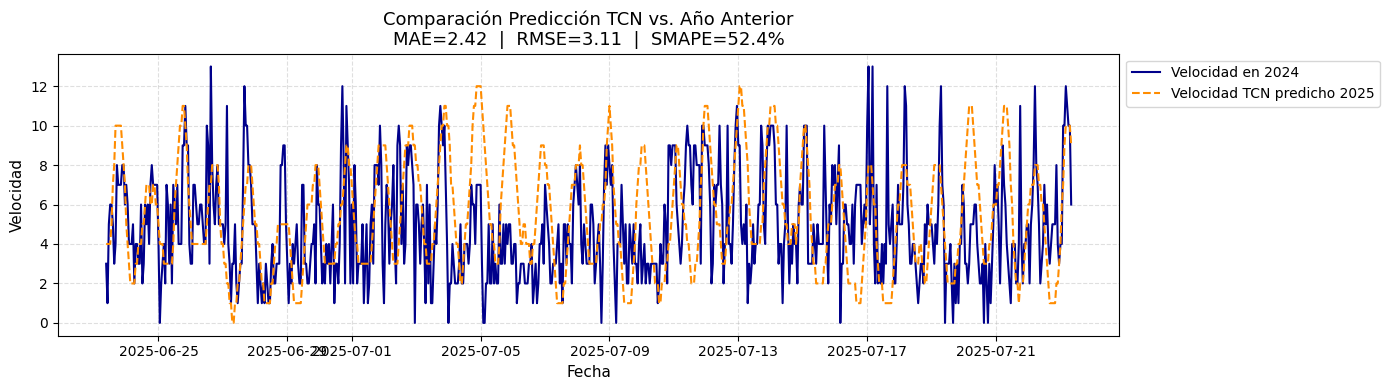

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Cargar datos
df_real = pd.read_excel("Datos_290004_con_predicciones_covariables_filtrado_2024.xlsx", parse_dates=["momento"])
df_pred = pd.read_excel("pred_ff_Valor_720h_con_lag.xlsx", sheet_name="ff_Valor_pred", parse_dates=["momento"])

# 2) Definir fechas
fecha_ini_2025 = pd.Timestamp("2025-06-23 09:00")
fecha_fin_2025 = fecha_ini_2025 + pd.Timedelta(hours=719)
fecha_ini_2024 = pd.Timestamp("2024-06-23 09:00")
fecha_fin_2024 = fecha_ini_2024 + pd.Timedelta(hours=719)

# 3) Filtrar
real_2024 = df_real[(df_real["momento"] >= fecha_ini_2024) & (df_real["momento"] <= fecha_fin_2024)].copy()
pred_2025 = df_pred[(df_pred["momento"] >= fecha_ini_2025) & (df_pred["momento"] <= fecha_fin_2025)].copy()

# 4) Alineación
real_2024 = real_2024.reset_index(drop=True)
pred_2025 = pred_2025.reset_index(drop=True)

# 5) Preprocesamiento
real_vals = real_2024["ff_Valor"].clip(lower=0).values.reshape(-1, 1)
pred_vals_raw = pred_2025["ff_Valor_pred"].clip(lower=0).values.reshape(-1, 1)

# Escalado entre 0 y 1
scaler = MinMaxScaler()
scaler.fit(real_vals)
real_vals_scaled = scaler.transform(real_vals)
pred_vals_scaled = scaler.transform(pred_vals_raw)

# Suavizado y redondeo sobre escala real (reescalado luego de suavizar)
pred_vals_smooth = gaussian_filter1d(pred_vals_scaled.flatten(), sigma=2).reshape(-1, 1)
pred_vals_smooth_rounded = np.round(scaler.inverse_transform(pred_vals_smooth)).flatten()
real_vals_rescaled = real_vals.flatten()

# Cortar iguales
n = min(len(real_vals_rescaled), len(pred_vals_smooth_rounded))
real_vals_rescaled = real_vals_rescaled[:n]
pred_vals_smooth_rounded = pred_vals_smooth_rounded[:n]
horas = pred_2025["momento"].values[:n]

# SMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_pred - y_true)[mask] / denominator[mask]) * 100

# Métricas
mae = mean_absolute_error(real_vals_rescaled, pred_vals_smooth_rounded)
rmse = np.sqrt(mean_squared_error(real_vals_rescaled, pred_vals_smooth_rounded))
smape_val = smape(real_vals_rescaled, pred_vals_smooth_rounded)

# Mostrar métricas
print("═════════════════════════════════════════════════════════")
print("     Comparación TCN (2025) vs. Año Anterior (2024)")
print("═════════════════════════════════════════════════════════")
print(f"MAE    : {mae:.3f}")
print(f"RMSE   : {rmse:.3f}")
print(f"SMAPE  : {smape_val:.2f}%")
print("═════════════════════════════════════════════════════════")

# Gráfico
plt.figure(figsize=(14, 4))
plt.plot(horas, real_vals_rescaled, label="Velocidad en 2024", color='darkblue')
plt.plot(horas, pred_vals_smooth_rounded, label="Velocidad TCN predicho 2025", color='darkorange', linestyle='--')
plt.title(f"Comparación Predicción TCN vs. Año Anterior\nMAE={mae:.2f}  |  RMSE={rmse:.2f}  |  SMAPE={smape_val:.1f}%", fontsize=13)
plt.xlabel("Fecha", fontsize=11)
plt.ylabel("Velocidad", fontsize=11)
plt.legend(loc='upper left', bbox_to_anchor=(1.00, 1.00))
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.ndimage import gaussian_filter1d
import numpy as np

# --- 1) Obtener y aplanar + clippeo (evaluación cruda sin suavizado ni escalado)
y_true = np.clip(Y_test.flatten(), 0, None)
y_pred = np.clip(model.predict(X_test).flatten(), 0, None)

# --- 2) Cálculo de métricas de error bruto
mae   = mean_absolute_error(y_true, y_pred)
rmse  = np.sqrt(mean_squared_error(y_true, y_pred))

# --- 3) Mostrar resultados
print("≫ Evaluación del testeo del modelo TCN :")
print(f"   - MAE   = {mae:.3f}")
print(f"   - RMSE  = {rmse:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
≫ Evaluación del testeo del modelo TCN :
   - MAE   = 0.302
   - RMSE  = 0.527


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- 1) Obtener y aplanar + clippeo (evaluación cruda sin suavizado ni escalado)
y_train_true = np.clip(Y_train.flatten(), 0, None)
y_train_pred = np.clip(model.predict(X_train).flatten(), 0, None)

# --- 2) Cálculo de métricas de error bruto
mae_train   = mean_absolute_error(y_train_true, y_train_pred)
rmse_train  = np.sqrt(mean_squared_error(y_train_true, y_train_pred))

# --- 3) Mostrar resultados
print("≫ Evaluación del entrenamiento del modelo TCN:")
print(f"   - MAE   = {mae_train:.3f}")
print(f"   - RMSE  = {rmse_train:.3f}")


74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step
≫ Evaluación del entrenamiento del modelo TCN:
   - MAE   = 0.307
   - RMSE  = 0.529


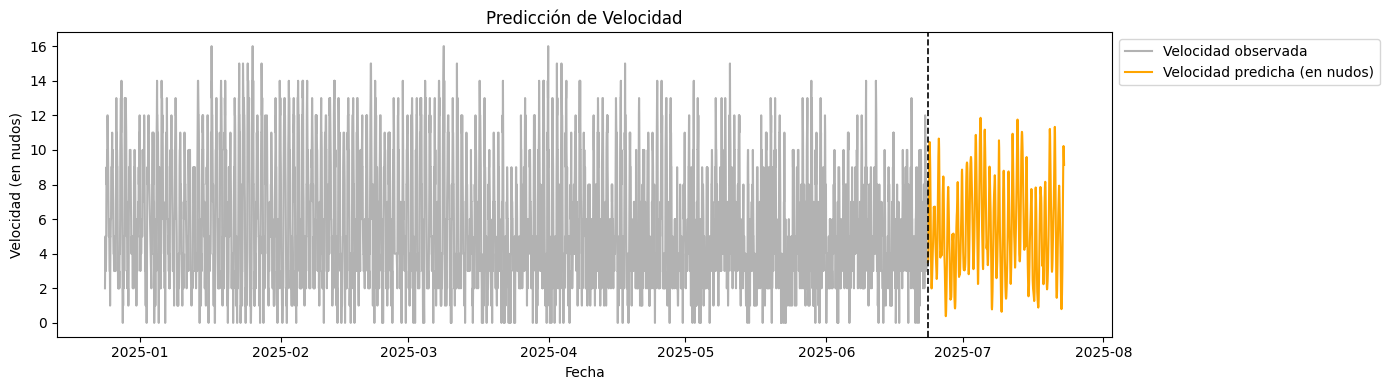

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Leer datos desde Excel
df_real = pd.read_excel("pred_ff_Valor_720h_con_lag.xlsx", sheet_name="historico", parse_dates=["momento"])
df_pred = pd.read_excel("pred_ff_Valor_720h_con_lag.xlsx", sheet_name="ff_Valor_pred", parse_dates=["momento"])

# 2) Preparar
df_real["momento"] = pd.to_datetime(df_real["momento"])
df_pred["momento"] = pd.to_datetime(df_pred["momento"])

df_real = df_real.set_index("momento")
df_pred = df_pred.set_index("momento")

# 3) Cortar últimos 720 puntos observados
n_obs = 720
real_tramo = df_real["ff_Valor"].iloc[-n_obs:]


# 4) Limpiar valores negativos
df_pred['ff_Valor_pred'] = df_pred["ff_Valor_pred"].clip(lower=0)
pred_suave = gaussian_filter1d(df_pred['ff_Valor_pred'], sigma=2)
# 5) Graficar
plt.figure(figsize=(14, 4))
plt.plot(df_real.index, df_real["ff_Valor"], label="Velocidad observada", color='gray', alpha=0.6)
plt.plot(df_pred.index, pred_suave, label="Velocidad predicha (en nudos)", color='orange')

# Línea de corte
cutoff = pd.Timestamp("2025-06-23 08:00")
plt.axvline(cutoff, color="black", linestyle="dashed", linewidth=1.2)

# Estética
plt.title("Predicción de Velocidad")
plt.xlabel("Fecha")
plt.ylabel("Velocidad (en nudos)")
leg = plt.legend(loc='upper left', bbox_to_anchor=(1.00, 1.00))
plt.tight_layout()  # Ajusta automáticamente los márgenes para que quepa todo
plt.show()


74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


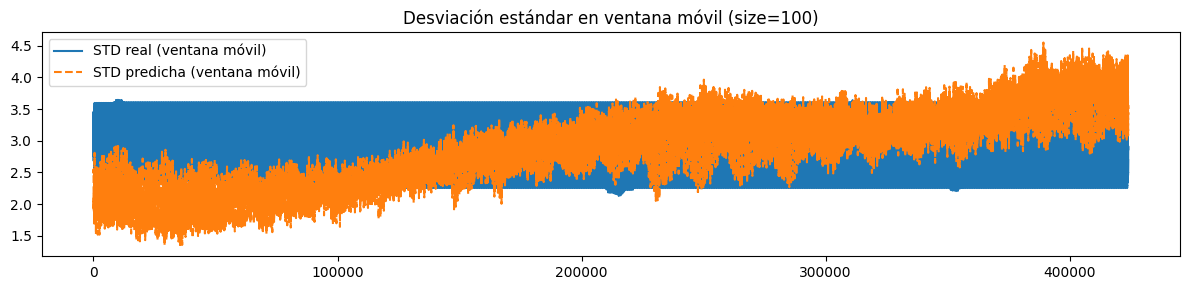

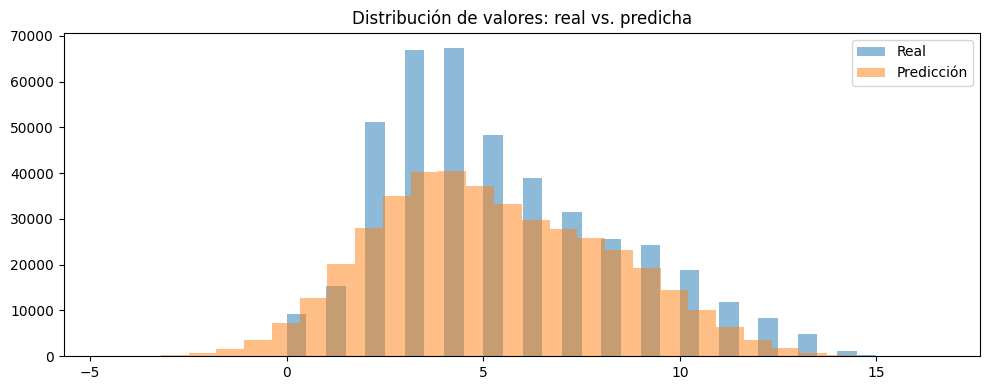

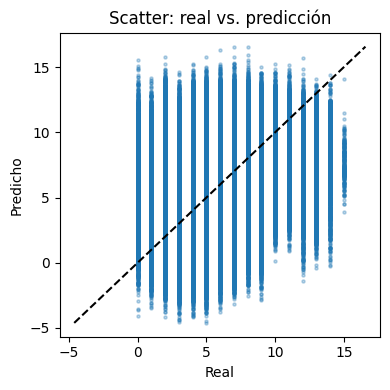

{'std_true': np.float32(2.9894457), 'std_pred': np.float32(2.940532), 'explained_variance_score': -0.17586195468902588, 'levene_stat': np.float64(7.740623835038687), 'levene_pvalue': np.float64(0.005399333767254508), 'std_true_window': array([3.3909566, 3.3822322, 3.3794389, ..., 2.8656094, 2.8656094,
       2.8656623], dtype=float32), 'std_pred_window': array([2.4828327, 2.4970367, 2.493784 , ..., 3.441264 , 3.4531362,
       3.4087284], dtype=float32)}


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
from scipy.stats import levene

def evaluar_variabilidad(y_true, y_pred, window=None):
    """
    Calcula métricas y gráficos para comparar la variabilidad
    de y_true vs. y_pred.

    Parámetros:
    -----------
    y_true: array-like
        Valores reales.
    y_pred: array-like
        Valores predichos.
    window: int o None
        Si se especifica, calcula STD y varianza en ventanas móviles de tamaño window.

    Devuelve:
    ---------
    results: dict
        Diccionario con métricas de variabilidad.
    """
    # Aplanar y asegurar numpy arrays
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()

    # 1) Desviaciones estándar globales
    std_true = np.std(y_true, ddof=1)
    std_pred = np.std(y_pred, ddof=1)
    ratio_std = std_pred / std_true

    # 2) Varianzas globales
    var_true = np.var(y_true, ddof=1)
    var_pred = np.var(y_pred, ddof=1)
    ratio_var = var_pred / var_true

    # 3) Explained Variance Score
    evs = explained_variance_score(y_true, y_pred)

    # 4) Prueba de igualdad de varianzas (Levene)
    stat, p_val = levene(y_true, y_pred)

    results = {
        "std_true": std_true,
        "std_pred": std_pred,
        "explained_variance_score": evs,
        "levene_stat": stat,
        "levene_pvalue": p_val,
    }

    # 5) Si se pide ventana móvil
    if window is not None and window < len(y_true):
        rolls = len(y_true) - window + 1
        std_true_win = np.array([
            np.std(y_true[i : i+window], ddof=1) for i in range(rolls)
        ])
        std_pred_win = np.array([
            np.std(y_pred[i : i+window], ddof=1) for i in range(rolls)
        ])
        results["std_true_window"] = std_true_win
        results["std_pred_window"] = std_pred_win

        # Gráfico de STD móvil
        plt.figure(figsize=(12,3))
        plt.plot(std_true_win, label="STD real (ventana móvil)")
        plt.plot(std_pred_win, label="STD predicha (ventana móvil)", linestyle="--")
        plt.title(f"Desviación estándar en ventana móvil (size={window})")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 6) Histogramas superpuestos
    plt.figure(figsize=(10,4))
    plt.hist(y_true, bins=30, alpha=0.5, label="Real")
    plt.hist(y_pred, bins=30, alpha=0.5, label="Predicción")
    plt.title("Distribución de valores: real vs. predicha")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 7) Scatter real vs pred
    plt.figure(figsize=(4,4))
    plt.scatter(y_true, y_pred, s=5, alpha=0.3)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, 'k--')
    plt.title("Scatter: real vs. predicción")
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.tight_layout()
    plt.show()

    return results

# Ejemplo de uso:

# 1) Predicciones escaladas
Y_pred_train_scaled = model.predict(X_train)
Y_pred_test_scaled  = model.predict(X_test)

# 2) Invertir la escala a unidades originales
Y_pred_train = y_scaler.inverse_transform(
    Y_pred_train_scaled.reshape(-1, 1)
).reshape(Y_pred_train_scaled.shape)
Y_train_orig = y_scaler.inverse_transform(
    Y_train.reshape(-1, 1)
).reshape(Y_train.shape)
y_train_true = Y_train_orig.flatten()
y_train_pred = Y_pred_train.flatten()
Y_pred_test = y_scaler.inverse_transform(
    Y_pred_test_scaled.reshape(-1, 1)
).reshape(Y_pred_test_scaled.shape)
Y_test_orig = y_scaler.inverse_transform(
    Y_test.reshape(-1, 1)
).reshape(Y_test.shape)
y_true_flat = Y_test_orig.flatten()
y_pred_flat = Y_pred_test.flatten()
metrics = evaluar_variabilidad(y_true_flat, y_pred_flat, window=100)
print(metrics)


In [10]:
# prompt: Dame la observacion 24 de df_pred 168 y la 720

print(df_pred.iloc[23])
print(df_pred.iloc[167])
print(df_pred.iloc[719])

ff_Valor_pred    3.229655
Name: 2025-06-24 08:00:00, dtype: float64
ff_Valor_pred    5.142999
Name: 2025-06-30 08:00:00, dtype: float64
ff_Valor_pred    8.41562
Name: 2025-07-23 08:00:00, dtype: float64
